This notebook ilustrates the effects of fitting a pretrained model to the set of new observations.

In [2]:
# imports
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

2023-06-20 11:47:30.213384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 11:47:30.214932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 11:47:30.246466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 11:47:30.246959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 11:47:30.818419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
N = 1000 # data points
L = 1 # periods

x = np.arange(N) * L * 2 * np.pi / N
y = np.sin(x)

# Select only datapoints with only non-negative values
dataset_base = np.column_stack((x,y))
dataset_base = dataset_base[dataset_base[:,1] >= 0]
x1 = dataset_base[:,0]
y1 = dataset_base[:,1]

# Select only datapoints with only negative values
dataset_additional = np.column_stack((x,y))
dataset_additional = dataset_additional[dataset_additional[:,1] < 0]
x2 = dataset_additional[:,0]
y2 = dataset_additional[:,1]

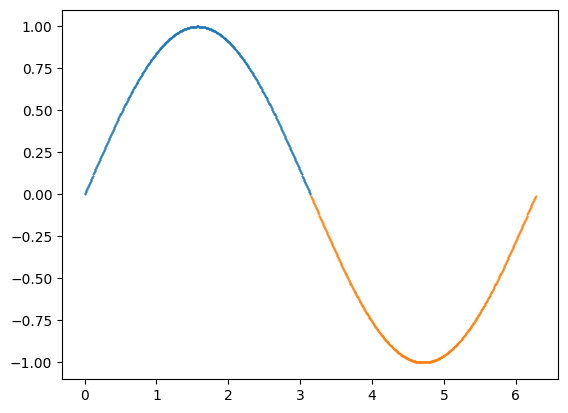

In [4]:
plt.plot(x1,y1,".",markersize=1)
plt.plot(x2,y2,".",markersize=1)
plt.show()

In [5]:
def get_model():
    ''' Returna a compiled, untrained model '''
    inputs = tf.keras.layers.Input(shape=(1,))

    v = tf.keras.layers.Dense(512)(inputs)
    v = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(v)

    output = tf.keras.layers.Dense(1)(v)

    model = tf.keras.Model([inputs], output)
    model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.SGD())

    return model

def get_trained_model(x1, y1):
    ''' Returns a trained model '''
    model = get_model()
    model.fit(x1,y1, batch_size=8, epochs=1000, verbose=0)
    model.trainable = False
    return model

def experiment_1(x1, y1, x2, y2):
    ''' Returns base model refited with just the new set of observations '''
    model = get_trained_model(x1, y1)

    model.fit(x2,y2, batch_size=8, epochs=1000, verbose=0)

    return model

def experiment_2(x1, y1, x, y):
    ''' Returns base model refited with all (base and new) observations '''
    model = get_trained_model(x1, y1)

    model.fit(x,y, batch_size=8, epochs=1000, verbose=0)

    return model

def experiment_3(x1, y1, x2, y2):
    ''' Returns base model refited with the new set of observations and a portion (20%) of base observations '''
    model = get_trained_model(x1, y1)

    random_idx = np.random.choice(x1.shape[0], x1.shape[0]//10)
    x = np.concatenate((x1[random_idx], x2))
    y = np.concatenate((y1[random_idx], y2))
    
    model.fit(x,y, batch_size=8, epochs=1000, verbose=0)
    return model


In [8]:
m0 = get_trained_model(x1, y1)

In [6]:
# Run experments
m1 = experiment_1(x1, y1, x2, y2)
m2 = experiment_2(x1, y1, x, y)
m3 = experiment_3(x1, y1, x2, y2)

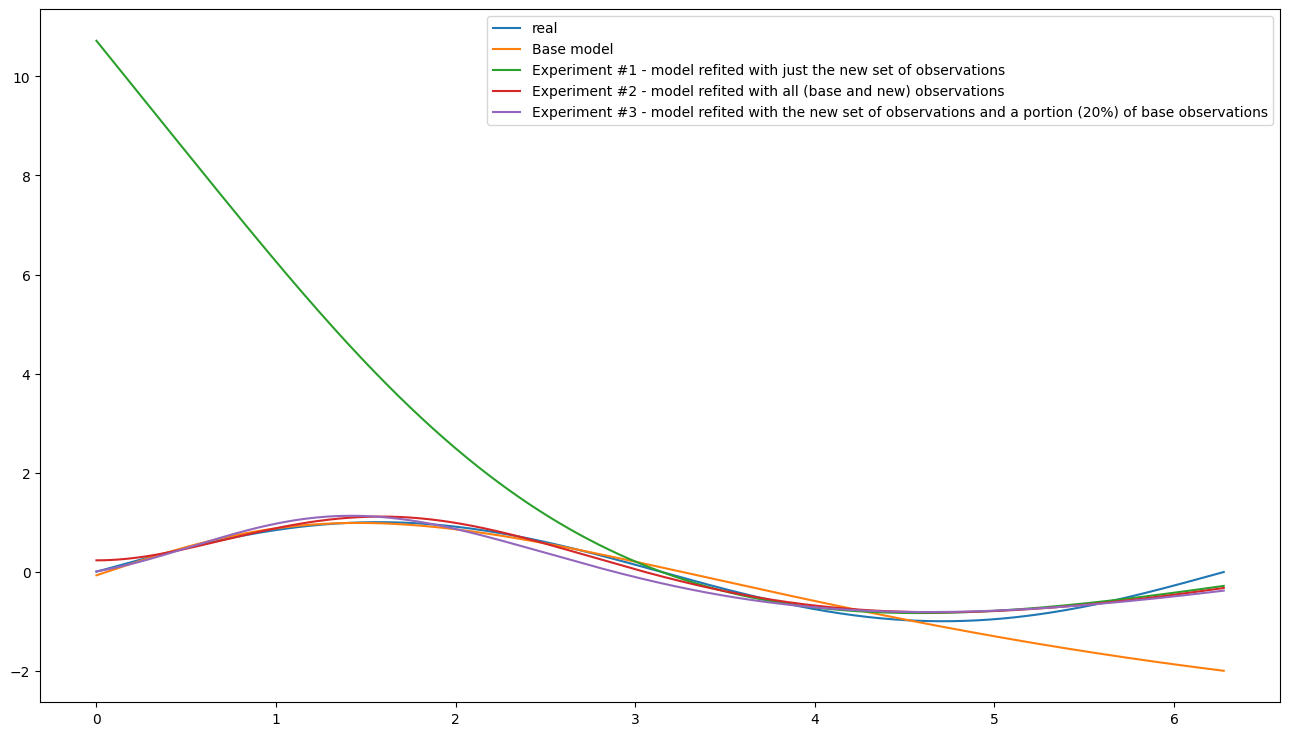

In [15]:
# Plot predictions vs real observations
plt.figure(figsize=(16,9))
plt.plot(x,y,"-",markersize=1, label="real")
plt.plot(x,m0.predict(x, verbose=0),markersize=1, label="Base model")
plt.plot(x,m1.predict(x, verbose=0),markersize=1, label="Experiment #1 - model refited with just the new set of observations")
plt.plot(x,m2.predict(x, verbose=0),markersize=1, label="Experiment #2 - model refited with all (base and new) observations")
plt.plot(x,m3.predict(x, verbose=0),markersize=1, label="Experiment #3 - model refited with the new set of observations and a portion (20%) of base observations")
plt.legend()
plt.show()